In [1]:
import pyreadr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.linear_model import LassoCV, LogisticRegressionCV
from lightgbm import LGBMRegressor, LGBMClassifier

from doubleml.data import DoubleMLPanelData
from doubleml.did import DoubleMLDIDMulti
import warnings

warnings.filterwarnings('ignore')

# Download and process data

In [2]:
mpdta = pd.read_parquet('/Users/mcargnel/Documents/mea/tesis/data/mpdta.parquet')
mpdta.head()

,year,countyreal,lpop,lemp,first.treat,treat
0,2003,8001.0,5.896761,8.461469,2007.0,1.0
1,2004,8001.0,5.896761,8.336870,2007.0,1.0
2,2005,8001.0,5.896761,8.340217,2007.0,1.0
3,2006,8001.0,5.896761,8.378161,2007.0,1.0
4,2007,8001.0,5.896761,8.487352,2007.0,1.0


In [3]:
mpdta['countyreal'] = mpdta['countyreal'].astype(int)
mpdta['first.treat'] = mpdta['first.treat'].astype(int)
mpdta['treat'] = mpdta['treat'].astype(int)

# Set values for treatment group indicator for never-treated to np.inf
mpdta.loc[mpdta['first.treat'] == 0, 'first.treat'] = np.inf

In [4]:
dml_data = DoubleMLPanelData(
    data=mpdta,
    y_col="lemp", # log teen employement
    d_cols="first.treat", # treatment, is minimun wage
    id_col="countyreal", # counties
    t_col="year",
    x_cols=['lpop'] # log of county population, should be time invariant
)
print(dml_data)

================== DoubleMLPanelData Object ==================

------------------ Data summary      ------------------
Outcome variable: lemp
Treatment variable(s): ['first.treat']
Covariates: ['lpop']
Instrument variable(s): None
Time variable: year
Id variable: countyreal
No. Unique Ids: 500
No. Observations: 2500

------------------ DataFrame info    ------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Columns: 6 entries, year to treat
dtypes: float64(3), int32(1), int64(2)
memory usage: 107.6 KB



# ATT Estimation: Conditional Parallel trends

## Linear and logistic regression

In [5]:
dml_obj_linear_logistic = DoubleMLDIDMulti(
    obj_dml_data=dml_data,
    ml_g=LinearRegression(),
    ml_m=LogisticRegression(penalty=None),
    control_group="never_treated",
    n_folds=10
)

================== DoubleMLDIDMulti Object ==================

------------------ Data summary      ------------------
Outcome variable: lemp
Treatment variable(s): ['first.treat']
Covariates: ['lpop']
Instrument variable(s): None
Time variable: year
Id variable: countyreal
No. Unique Ids: 500
No. Observations: 2500

------------------ Score & algorithm ------------------
Score function: observational
Control group: never_treated
Anticipation periods: 0

------------------ Machine learner   ------------------
Learner ml_g: LinearRegression()
Learner ml_m: LogisticRegression(penalty=None)
Out-of-sample Performance:
Regression:
Learner ml_g0 RMSE: [[0.17122318 0.18279557 0.25764214 0.25868974 0.17170601 0.15153853
  0.20210027 0.20640486 0.17198548 0.15154764 0.20125169 0.16475094]]
Learner ml_g1 RMSE: [[0.10179393 0.12766589 0.14137808 0.14658877 0.13976588 0.11476696
  0.0869958  0.10346679 0.13341264 0.16110614 0.16049021 0.16081522]]
Classification:
Learner ml_m Log Loss: [[0.2322406

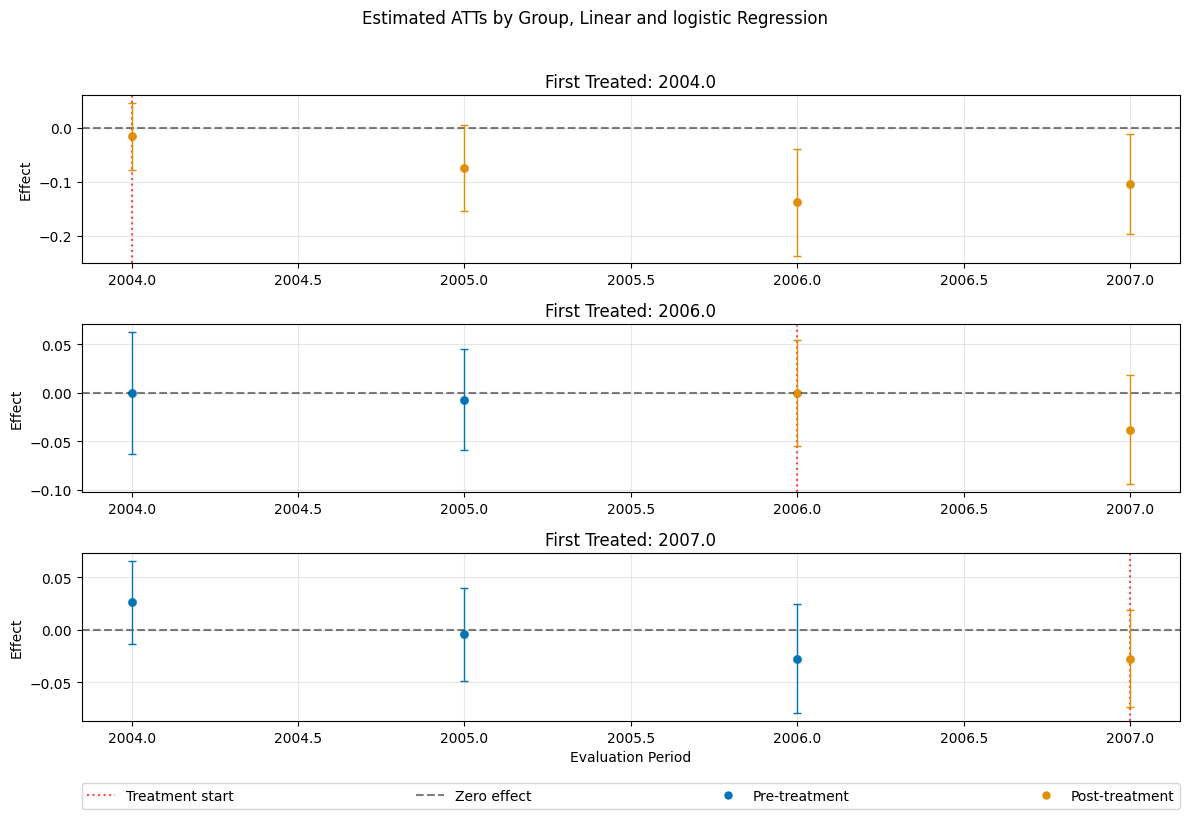

In [11]:
dml_obj_linear_logistic.fit()
dml_obj_linear_logistic.bootstrap(n_rep_boot=5000)
dml_obj_linear_logistic.plot_effects(title="Estimated ATTs by Group, Linear and logistic Regression")
print(dml_obj_linear_logistic)

(<Figure size 1200x600 with 1 Axes>,
 <Axes: title={'center': 'Agg. Estimated ATTs by Group, Linear and logistic Regression'}, ylabel='Effect'>)

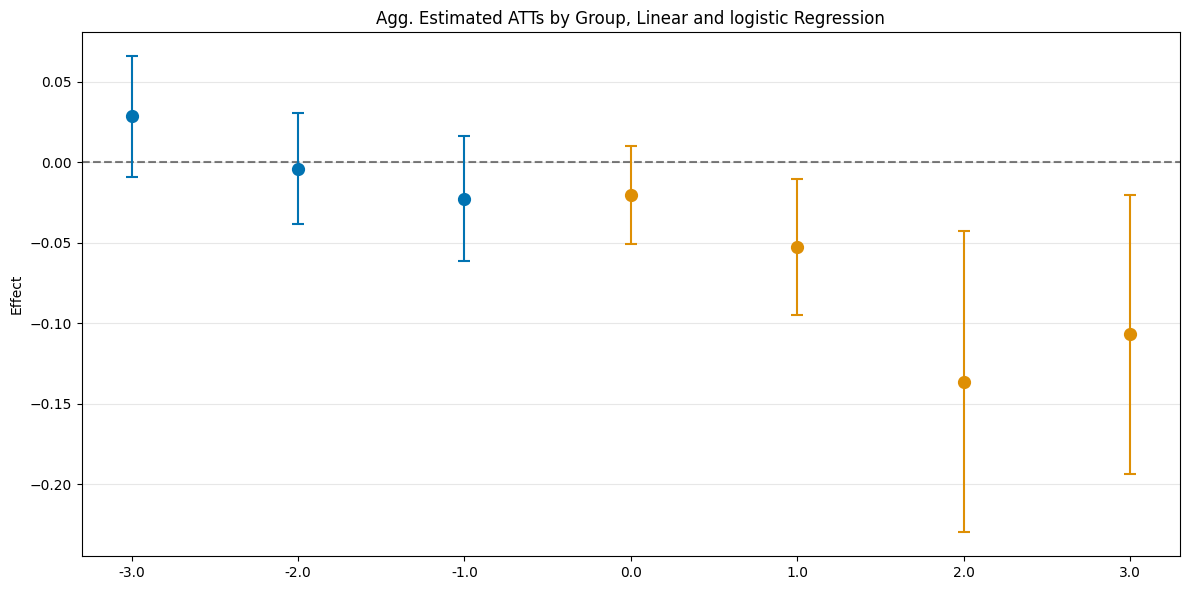

In [8]:
es_linear_logistic = dml_obj_linear_logistic.aggregate("eventstudy")
es_linear_logistic.aggregated_frameworks.bootstrap()
es_linear_logistic.plot_effects(title="Agg. Estimated ATTs by Group, Linear and logistic Regression")

## Lasso and Logistic Regression

================== DoubleMLDIDMulti Object ==================

------------------ Data summary      ------------------
Outcome variable: lemp
Treatment variable(s): ['first.treat']
Covariates: ['lpop']
Instrument variable(s): None
Time variable: year
Id variable: countyreal
No. Unique Ids: 500
No. Observations: 2500

------------------ Score & algorithm ------------------
Score function: observational
Control group: never_treated
Anticipation periods: 0

------------------ Machine learner   ------------------
Learner ml_g: LassoCV()
Learner ml_m: LogisticRegressionCV()
Out-of-sample Performance:
Regression:
Learner ml_g0 RMSE: [[0.17290631 0.18152979 0.2590067  0.25872891 0.17365058 0.15212368
  0.20170494 0.20545552 0.17410739 0.1527839  0.20079878 0.16365845]]
Learner ml_g1 RMSE: [[0.10441817 0.12947846 0.13713926 0.15556119 0.13812424 0.11219515
  0.08795684 0.10903684 0.13145439 0.16121298 0.15902186 0.15983034]]
Classification:
Learner ml_m Log Loss: [[0.22913724 0.22913553 0.2291

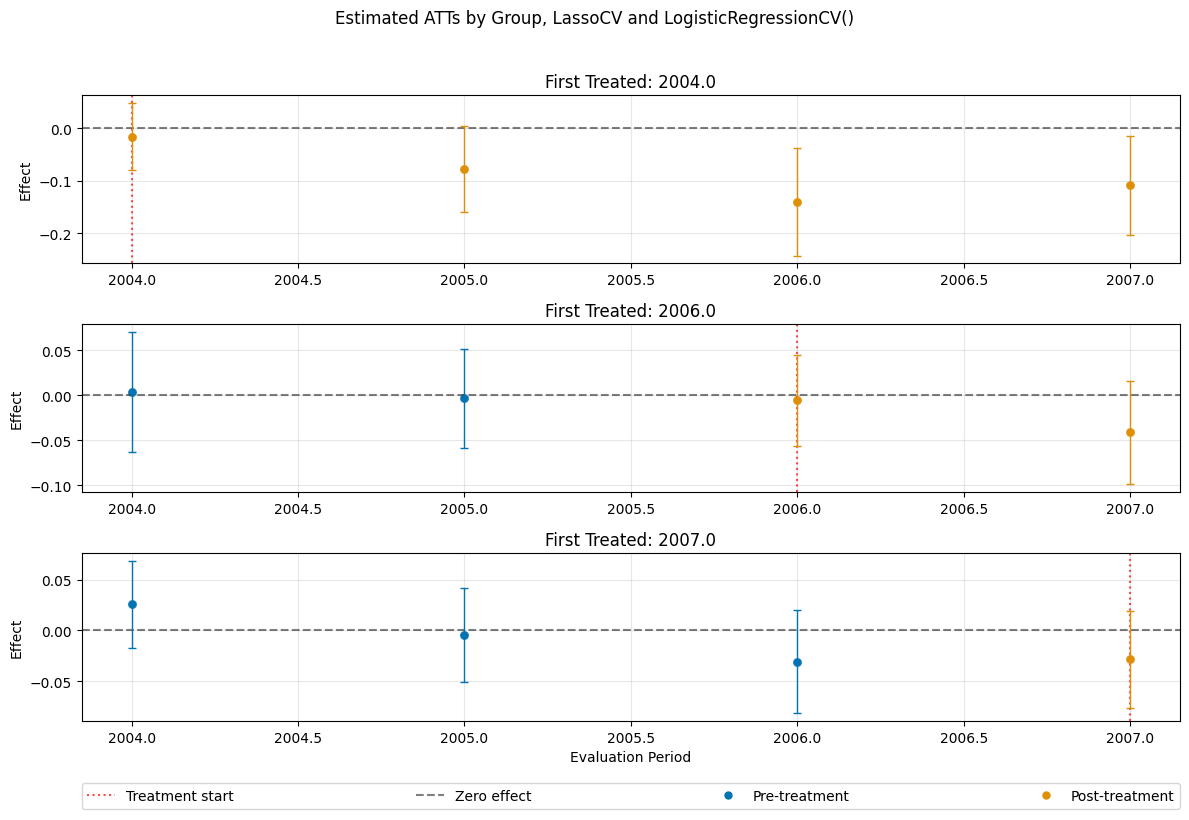

In [9]:
dml_obj_lasso = DoubleMLDIDMulti(
    obj_dml_data=dml_data,
    ml_g=LassoCV(),
    ml_m=LogisticRegressionCV(),
    control_group="never_treated",
    n_folds=10
)

dml_obj_lasso.fit()
dml_obj_lasso.bootstrap(n_rep_boot=5000)
dml_obj_lasso.plot_effects(title="Estimated ATTs by Group, LassoCV and LogisticRegressionCV()")
# Model summary
print(dml_obj_lasso)

(<Figure size 1200x600 with 1 Axes>,
 <Axes: title={'center': 'Agg. Estimated ATTs by Group, LassoCV and LogisticRegressionCV()'}, ylabel='Effect'>)

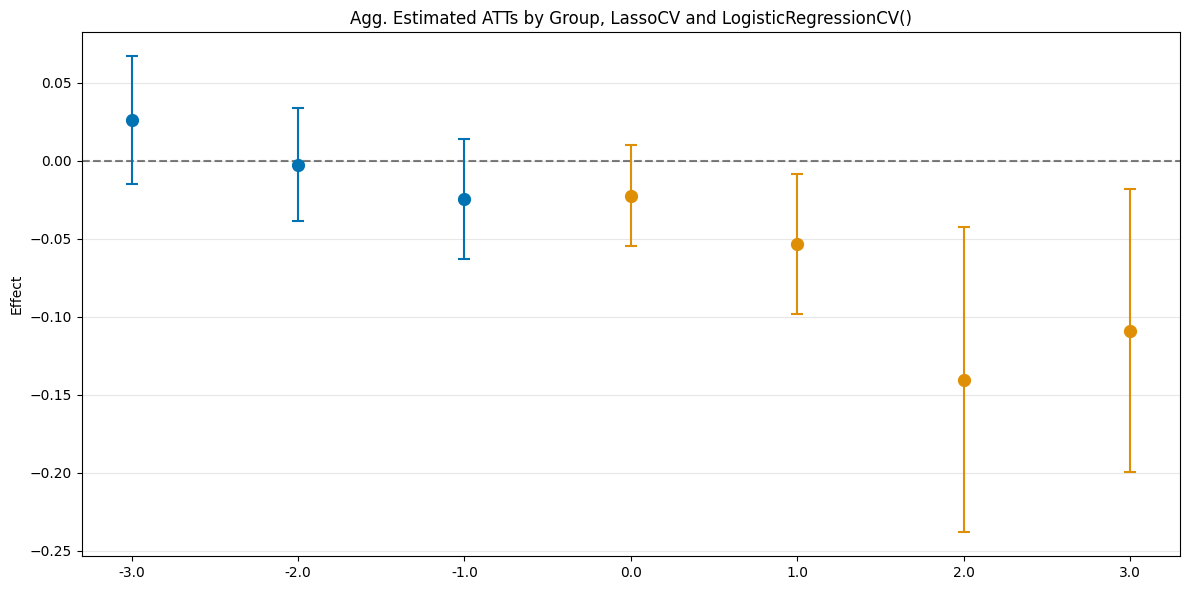

In [10]:
es_rf = dml_obj_lasso.aggregate("eventstudy")
es_rf.aggregated_frameworks.bootstrap()
es_rf.plot_effects(title="Agg. Estimated ATTs by Group, LassoCV and LogisticRegressionCV()")

## Tree methods

================== DoubleMLDIDMulti Object ==================

------------------ Data summary      ------------------
Outcome variable: lemp
Treatment variable(s): ['first.treat']
Covariates: ['lpop']
Instrument variable(s): None
Time variable: year
Id variable: countyreal
No. Unique Ids: 500
No. Observations: 2500

------------------ Score & algorithm ------------------
Score function: observational
Control group: never_treated
Anticipation periods: 0

------------------ Machine learner   ------------------
Learner ml_g: LGBMRegressor(learning_rate=0.01, n_estimators=500, random_state=123,
              verbose=-1)
Learner ml_m: LGBMClassifier(learning_rate=0.01, n_estimators=500, random_state=123,
               verbose=-1)
Out-of-sample Performance:
Regression:
Learner ml_g0 RMSE: [[0.17695148 0.19274485 0.26316971 0.26518452 0.1776558  0.15695441
  0.20502312 0.21177278 0.17564537 0.15738671 0.20405658 0.16979554]]
Learner ml_g1 RMSE: [[0.09710533 0.134751   0.15483024 0.14028957 

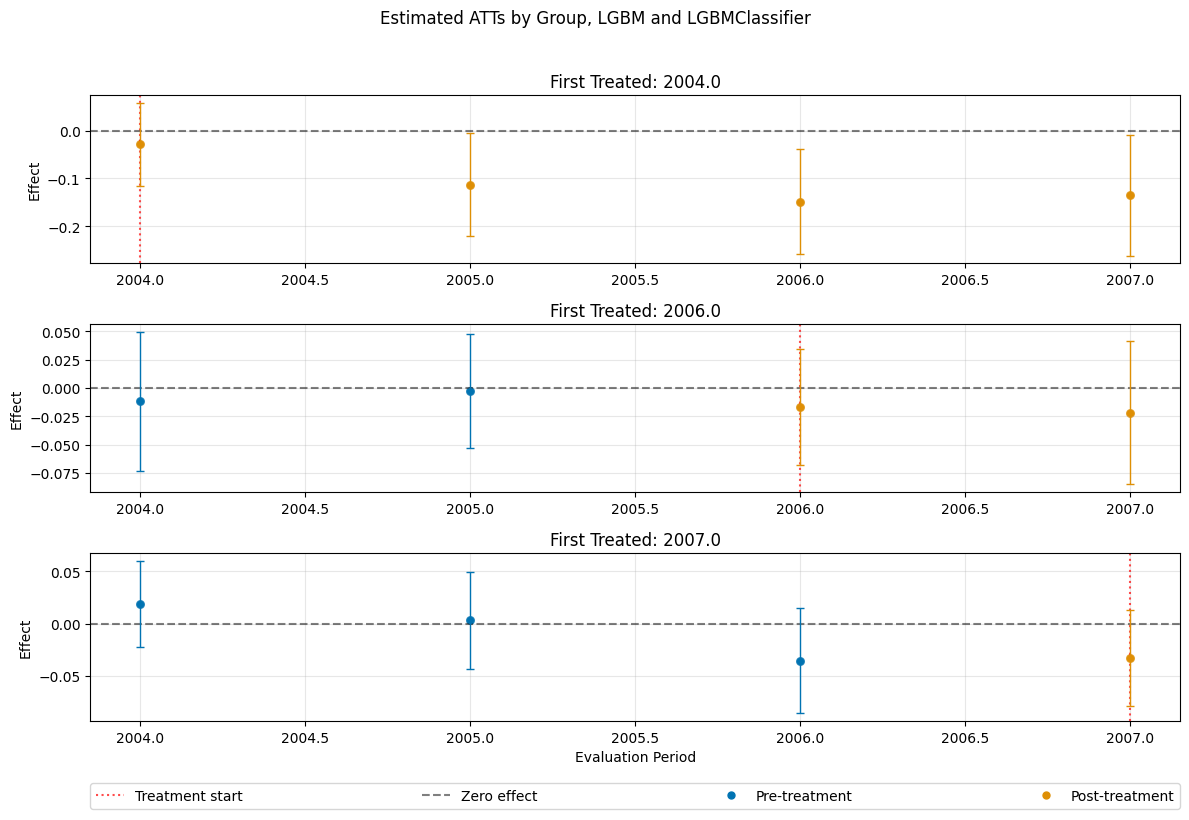

In [13]:
dml_obj_lgbm = DoubleMLDIDMulti(
    obj_dml_data=dml_data,
    ml_g=LGBMRegressor(n_estimators=500, learning_rate=0.01, verbose=-1, random_state=123),
    ml_m=LGBMClassifier(n_estimators=500, learning_rate=0.01, verbose=-1, random_state=123),
    control_group="never_treated",
    n_folds=5
)

dml_obj_lgbm.fit()
dml_obj_lgbm.bootstrap(n_rep_boot=5000)
dml_obj_lgbm.plot_effects(title="Estimated ATTs by Group, LGBM and LGBMClassifier")
# Model summary
print(dml_obj_lgbm)

================== DoubleMLDIDMulti Object ==================

------------------ Data summary      ------------------
Outcome variable: lemp
Treatment variable(s): ['first.treat']
Covariates: ['lpop']
Instrument variable(s): None
Time variable: year
Id variable: countyreal
No. Unique Ids: 500
No. Observations: 2500

------------------ Score & algorithm ------------------
Score function: observational
Control group: never_treated
Anticipation periods: 0

------------------ Machine learner   ------------------
Learner ml_g: LGBMRegressor(learning_rate=0.01, n_estimators=500, random_state=123,
              verbose=-1)
Learner ml_m: LGBMClassifier(learning_rate=0.01, n_estimators=500, random_state=123,
               verbose=-1)
Out-of-sample Performance:
Regression:
Learner ml_g0 RMSE: [[0.17047057 0.18690491 0.26727139 0.26518262 0.17695479 0.15768738
  0.2050561  0.21288576 0.17595902 0.15520859 0.2080219  0.17040829]]
Learner ml_g1 RMSE: [[0.09559907 0.13842013 0.15227717 0.1475289  

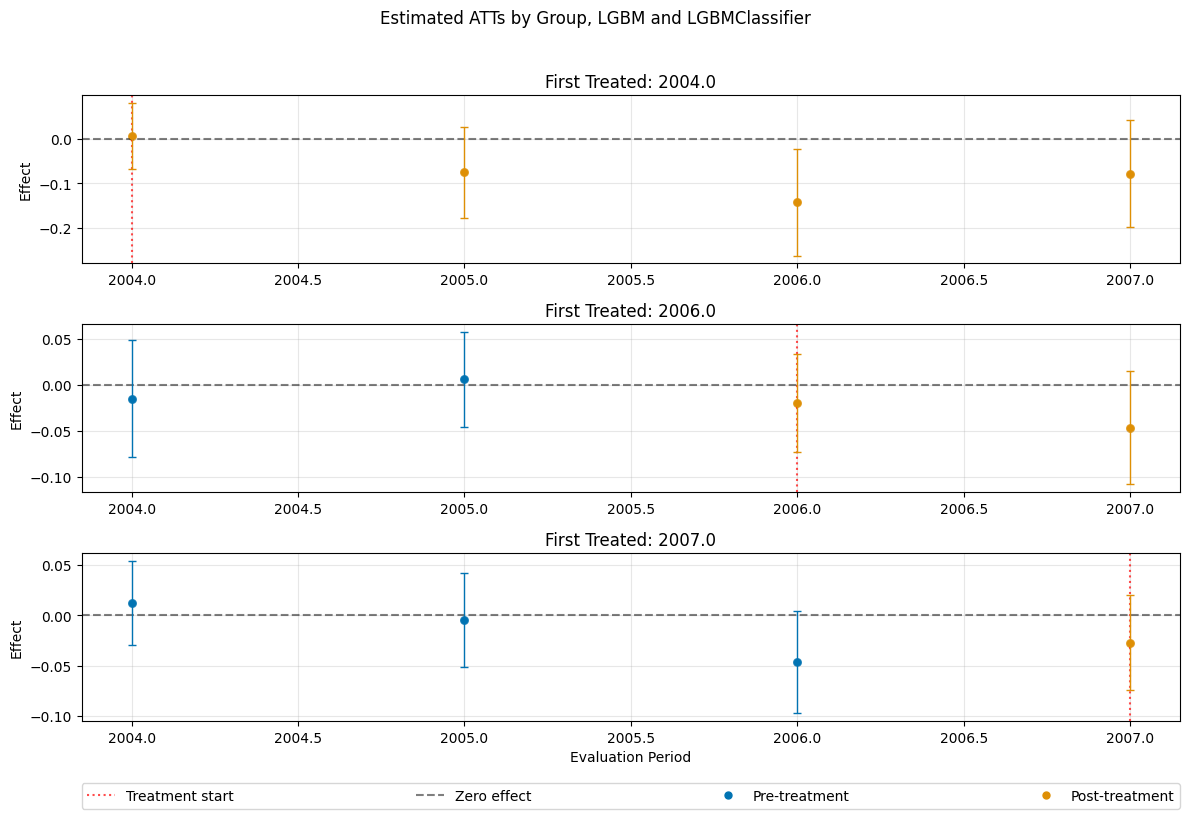

In [12]:
dml_obj_lgbm = DoubleMLDIDMulti(
    obj_dml_data=dml_data,
    ml_g=LGBMRegressor(n_estimators=500, learning_rate=0.01, verbose=-1, random_state=123),
    ml_m=LGBMClassifier(n_estimators=500, learning_rate=0.01, verbose=-1, random_state=123),
    control_group="never_treated",
    n_folds=5
)

dml_obj_lgbm.fit()
dml_obj_lgbm.bootstrap(n_rep_boot=5000)
dml_obj_lgbm.plot_effects(title="Estimated ATTs by Group, LGBM and LGBMClassifier")
# Model summary
print(dml_obj_lgbm)

(<Figure size 1200x600 with 1 Axes>,
 <Axes: title={'center': 'Agg. Estimated ATTs by Group, LGBM and LGBMClassifier()'}, ylabel='Effect'>)

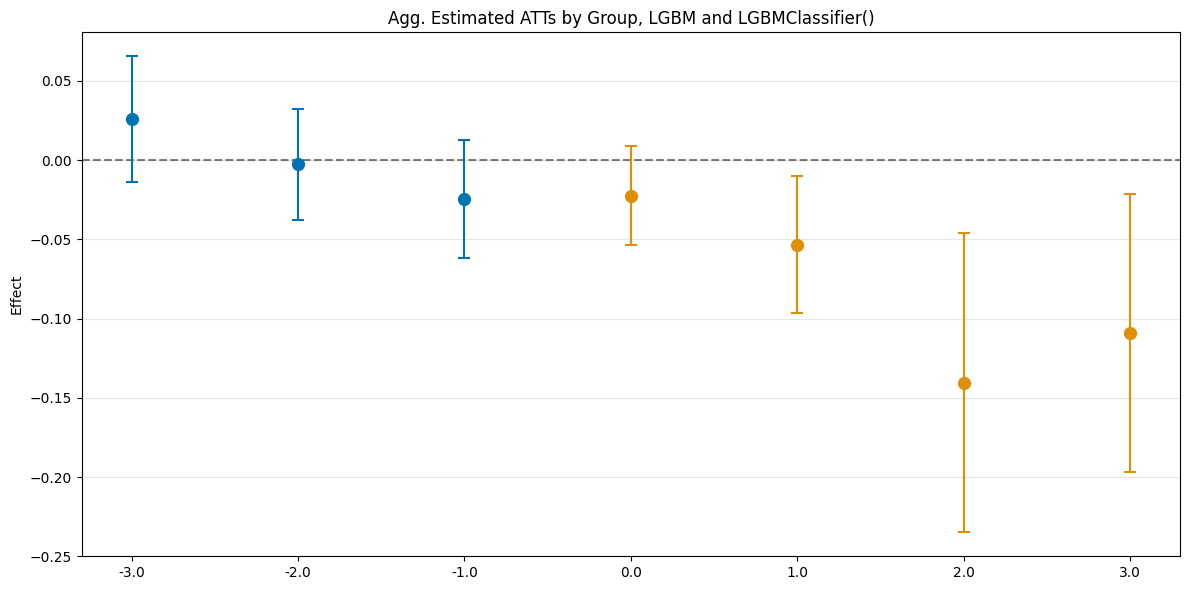

In [13]:
es_gbm = dml_obj_lasso.aggregate("eventstudy")
es_gbm.aggregated_frameworks.bootstrap()
es_gbm.plot_effects(title="Agg. Estimated ATTs by Group, LGBM and LGBMClassifier()")